In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os
import ast
from skimage.morphology import skeletonize


def to_tuple(t):
    return ast.literal_eval(t)
 
def unique_color(img):
    mask = img > 0
    only_color = img[mask]
    colors, count = np.unique(only_color, return_counts=True)
    max_color = colors[count.argmax()]
    #print(max_color)
    img[np.logical_not(mask)] = max_color
    return img

def maxDeviationThresh(hist):
    maximum = max(hist)
    index_max = list(hist).index(maximum)
    index_min = 0
    for i in range(0, index_max):
        if not hist[i] and hist[i + 1]:
            index_min = i
            break

    distances = []
    x1 = index_min
    y1 = hist[index_min]
    x2 = index_max
    y2 = hist[index_max]
    for i in range(index_min + 1, index_max):
        x0 = i
        y0 = hist[i]
        distance = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / np.sqrt(
            (y2 - y1) ** 2 + (x2 - x1) ** 2)
        distances.append(distance)
    if index_min < index_max - 1:
        T_index = distances.index(max(distances))
    else:
        T_index = -index_min
    return T_index + index_min


def extract_drawing(image):
    dst = cv2.bilateralFilter(image, 10, sigmaColor=15, sigmaSpace=15)
    # dst = img.copy()
    # max_occ = np.bincount(dst[dst > 0]).argmax()
    # dst[dst == 0] = max_occ
    threshed = np.ones(dst.shape, np.uint8) * 255
    if np.any(dst < 255):
        hist, _ = np.histogram(dst[dst < 255].flatten(), range(257))
        thresh_val = maxDeviationThresh(hist)
        #print(thresh_val)
        mask = dst < thresh_val
        threshed[mask] = 0
    return threshed

def getBackground(external, img, morph=True, ret_hier=False):
    background = np.zeros_like(img)
    points = np.array([external]).reshape((4, 1, 2))
    background = cv2.fillConvexPoly(background, points, (255, 255, 255))
    not_background = cv2.bitwise_not(background)
    background = cv2.bitwise_and(img, background)
    overlap = cv2.polylines(cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2RGB), [points], True, (255, 0, 0), 1)
    #plt.imshow(overlap)
    #plt.show()
    # background[background == 0] = 255
    # background = extract_drawing(background)
    background= cv2.bitwise_or(not_background, background)
    if morph:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        # background = cv2.bitwise_not(background)
        background = cv2.bitwise_not(cv2.erode(background, kernel))
        background = skeletonize(background / 255, method='lee').astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        background = cv2.dilate(background, kernel)
    else:
        background = cv2.bitwise_not(background)
        background = skeletonize(background / 255, method='lee').astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        background = cv2.dilate(background, kernel)
    #plt.imshow(background, cmap='gray')
    #plt.show()
    cnts, hier = cv2.findContours(background, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if ret_hier:
        return background, cnts, hier
    else:
        return background, cnts

# SVM with split in 4 (from predicted ROI)

In [2]:
def getSplitsFromROI(roi): 
    stripes = 2
    rois = []
    width_stripe = (roi[1][0] - roi[0][0]) / stripes
    height_stripe = (roi[2][1] - roi[1][1]) / stripes
    for i in range(stripes):
        for j in range(stripes):
            p0 = (roi[0][0] + j * width_stripe, roi[0][1] + i * height_stripe )
            p1 = (roi[0][0] + (j+1) * width_stripe, roi[0][1] + i * height_stripe )
            p2 = (roi[0][0] + (j+1) * width_stripe, roi[0][1] + (i+1) * height_stripe )
            p3 = (roi[0][0] + j * width_stripe, roi[0][1] + (i+1) * height_stripe )
            new_roi = [p0, p1, p2, p3]
            rois.append(new_roi)

    return np.array(rois).astype(int)



In [3]:


root = '../' #modificare se cartella rinominata
results_folder = os.path.join(root, 'results')
training_folder = os.path.join(root, 'dataset', 'training')
df_rail = pd.read_csv(os.path.join(results_folder, 'scores.csv'), header=0, usecols=['names', 'rect'], index_col='names', converters={'rect': to_tuple})
plt.rcParams['figure.figsize'] = [10, 5]
pixels = []

dataset = pd.read_csv(os.path.join(training_folder, 'DatabaseScoreByHand_training.csv'), header=0, index_col='CODICE', delimiter=',')
# print(linee_d.value_counts())
scoring=np.zeros(4)
hom_folder = os.path.join(root, 'dataset', 'threshed')
file_homog = pd.read_json(os.path.join(hom_folder, 'points.txt'), lines=True).set_index('name')

patterns = ['PATTERN5', 'PATTERN10', 'PATTERN12', 'PATTERN18', 'PATTERN3', 'PATTERN15', 'PATTERN17' ]
patternsName = ['cross', 'face', 'rail', 'triangle', 'rett_diag', 'rect', 'cross_vert']

y_data = []
X = [] 

for i in range(len(patterns)):
  coords = [852, 229, 1031, 531]#cambiare qui
  y_data.append([])
  X.append([])
  linee_d = dataset.loc[:, patterns[i]] #cambiare qui
  for img_path in os.listdir(hom_folder):
      if img_path.lower().endswith('.png'):
        name = img_path[:-4]      
        if name in linee_d.index:
          score = int(linee_d.loc[name])       
          scoring[score] += 1
          if score == 0:
            y_data[i].append(0)
            img = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.blur(img, (5, 5))
            if img_path[:-4] in df_rail.index:
              rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
              external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (rail_bbox[0], rail_bbox[1]+rail_bbox[3])]
              roiSplit = getSplitsFromROI(external)
              roiPixels = []
              imgcopy = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_COLOR)
              for roi in range(len(roiSplit)):
                background, _ = getBackground(roiSplit[roi], img, False)
                pixel = np.sum(np.divide(background, 255))
              # print('pixels {}'.format(pixel))
                imgcopy = cv2.rectangle(imgcopy, (roiSplit[roi][0][0], roiSplit[roi][0][1]), (roiSplit[roi][2][0], roiSplit[roi][2][1]), (255,0,0), 3)
                roiPixels.append(pixel)
              print(roiPixels, " ---- ", score)
              X[i].append(roiPixels)
            # else:
            #   x = coords[0] 
            #   y = coords[1] 
            #   w = np.abs(coords[0] - coords[2])
            #   h = np.abs(coords[1] - coords[3])
            #   external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            #   background, _ = getBackground(external, img, False)
            #   pixel = np.sum(np.divide(background, 255))
            #   # print('pixels {}'.format(pixel))
            #   X[i].append([0, pixel])
            # print('score 0, pixels {}'.format(pixel))
            
          else:
            y_data[i].append(1)
            img = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.blur(img, (5, 5))
            if img_path[:-4] in df_rail.index:
              rail_bbox = df_rail.loc[name].values[0][i]
              external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (rail_bbox[0], rail_bbox[1]+rail_bbox[3])]
              roiSplit = getSplitsFromROI(external)
              roiPixels = []
              imgcopy = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_COLOR)
              for roi in range(len(roiSplit)):
                background, _ = getBackground(roiSplit[roi], img, False)
                pixel = np.sum(np.divide(background, 255))
              # print('pixels {}'.format(pixel))
                imgcopy = cv2.rectangle(imgcopy, (roiSplit[roi][0][0], roiSplit[roi][0][1]), (roiSplit[roi][2][0], roiSplit[roi][2][1]), (255,0,0), 3)
                roiPixels.append(pixel)
              print(roiPixels, " ---- ", score)
              X[i].append(roiPixels)
            # else:
            #   x = coords[0] 
            #   y = coords[1] 
            #   w = np.abs(coords[0] - coords[2])
            #   h = np.abs(coords[1] - coords[3])
            #   external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            #   background, _ = getBackground(external, img, False)
            #   pixel = np.sum(np.divide(background, 255))
            #   # print('pixels {}'.format(pixel))
            #   X[i].append([0, pixel])
            # print('score 1, pixels {}'.format(pixel))


  # print(scoring)
  X[i] = np.array(X[i])
  y_data[i] = np.array(y_data[i])
  print(X[i].shape, y_data[i].shape)
  print("done ", patterns[i], " ", patternsName[i])
            



[389.0, 246.0, 336.3725490196078, 304.00000000000006]  ----  2
[343.0, 392.0, 335.0, 572.6274509803922]  ----  3
[121.0, 56.0, 503.0, 191.0]  ----  1
[329.0, 318.0, 257.8039215686276, 0.0]  ----  1
[84.7843137254902, 481.0, 263.0, 298.0]  ----  3
[38.0, 446.0, 254.40000000000006, 452.0]  ----  3
[241.60000000000008, 385.2, 2.631372549019608, 305.6]  ----  3
[591.0, 215.2156862745098, 341.0, 0.6078431372549019]  ----  3
[4.196078431372549, 541.0, 0.0, 408.0]  ----  3
[514.0, 106.0, 332.0, 436.0]  ----  3
[35.35686274509804, 397.7882352941176, 208.80000000000007, 320.62745098039215]  ----  3
[0.0, 1.2862745098039217, 567.0, 466.0]  ----  0
[99.0, 468.0, 382.0, 365.0]  ----  1
[272.0509803921569, 52.415686274509795, 227.56078431372543, 0.0]  ----  3
[383.0, 325.0, 368.0, 10.000000000000002]  ----  3
[176.7843137254902, 202.0, 2.7333333333333334, 323.0980392156863]  ----  1
[5.600000000000001, 419.8627450980393, 2.796078431372549, 395.84313725490193]  ----  3
[246.00000000000009, 365.67450

In [26]:
len(X[0])


342

SVM FOR  cross
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=10.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8940967283072545
train score: 0.9518716577540107
test score: 0.7909999999999999

cv score: 0.8940967283072545
train score: 0.9121951219512195
test score: 0.8248175182481752

Confusion matrix, without normalization
[[  9   3]
 [ 21 104]]


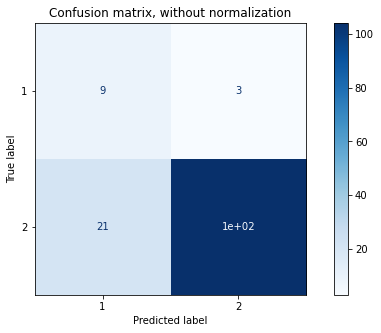

Normalized confusion matrix
[[0.75  0.25 ]
 [0.168 0.832]]


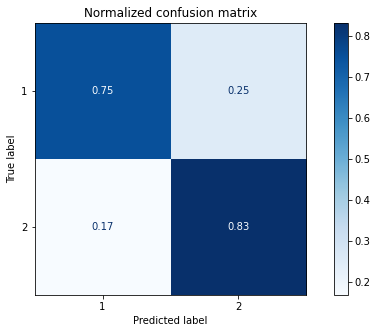

Best model with rbf kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8913229018492176
train score: 0.9358288770053476
test score: 0.8383333333333334

cv score: 0.8913229018492176
train score: 0.8829268292682927
test score: 0.7737226277372263

Confusion matrix, without normalization
[[11  1]
 [30 95]]


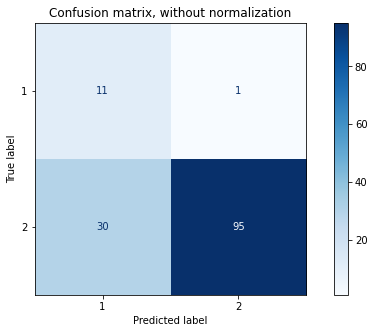

Normalized confusion matrix
[[0.91666667 0.08333333]
 [0.24       0.76      ]]


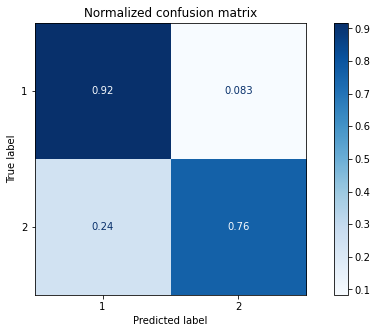

Best model with sigmoid kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8471787577050733
train score: 0.8418003565062389
test score: 0.904

cv score: 0.8471787577050733
train score: 0.848780487804878
test score: 0.8248175182481752

Confusion matrix, without normalization
[[ 12   0]
 [ 24 101]]


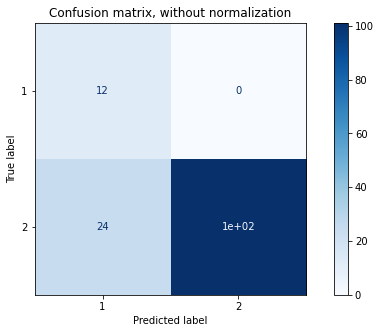

Normalized confusion matrix
[[1.    0.   ]
 [0.192 0.808]]


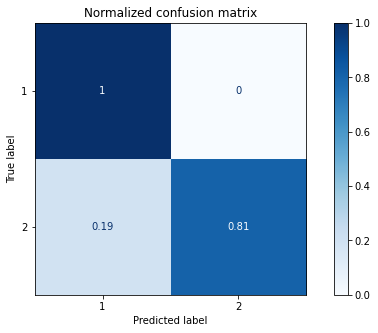

SVM FOR  face
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=4, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7179487179487181
train score: 0.9256410256410257
test score: 0.6027472527472527

cv score: 0.7179487179487181
train score: 0.8585365853658536
test score: 0.7591240875912408

Confusion matrix, without normalization
[[  3   4]
 [ 29 101]]


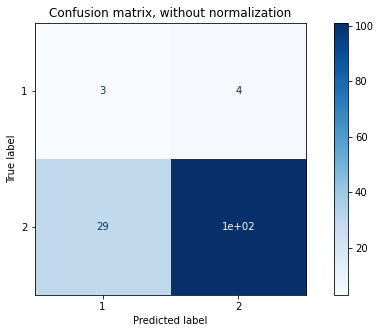

Normalized confusion matrix
[[0.42857143 0.57142857]
 [0.22307692 0.77692308]]


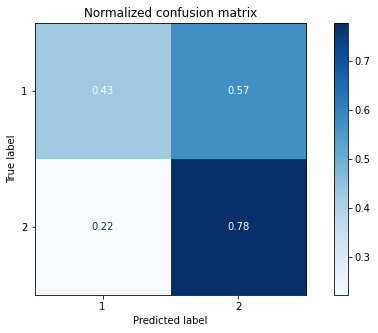

Best model with rbf kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6230769230769232
train score: 0.9256410256410257
test score: 0.5912087912087912

cv score: 0.6230769230769232
train score: 0.8585365853658536
test score: 0.7372262773722628

Confusion matrix, without normalization
[[ 3  4]
 [32 98]]


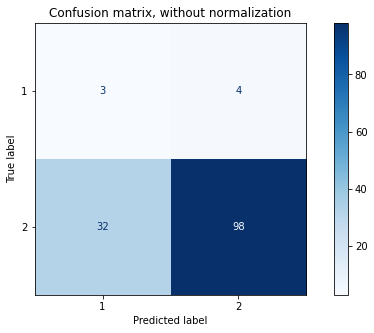

Normalized confusion matrix
[[0.42857143 0.57142857]
 [0.24615385 0.75384615]]


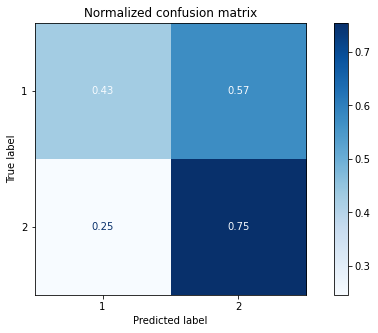

Best model with sigmoid kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=10.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6897435897435897
train score: 0.582051282051282
test score: 0.5835164835164836

cv score: 0.6897435897435897
train score: 0.7463414634146341
test score: 0.7226277372262774

Confusion matrix, without normalization
[[ 3  4]
 [34 96]]


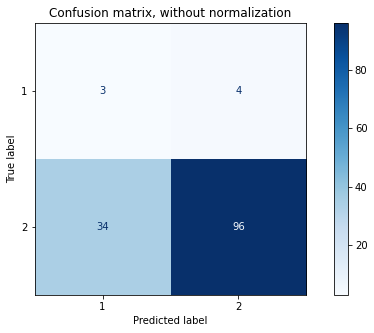

Normalized confusion matrix
[[0.42857143 0.57142857]
 [0.26153846 0.73846154]]


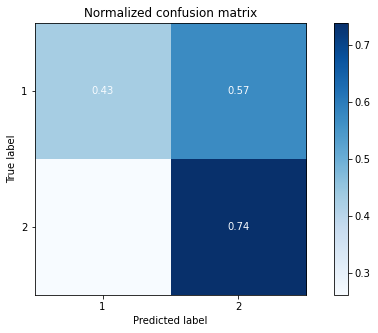

SVM FOR  rail
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8217948717948718
train score: 0.976923076923077
test score: 0.5967032967032967

cv score: 0.8217948717948718
train score: 0.9560975609756097
test score: 0.8759124087591241

Confusion matrix, without normalization
[[  2   5]
 [ 12 118]]


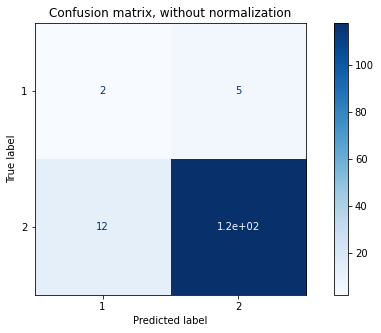

Normalized confusion matrix
[[0.28571429 0.71428571]
 [0.09230769 0.90769231]]


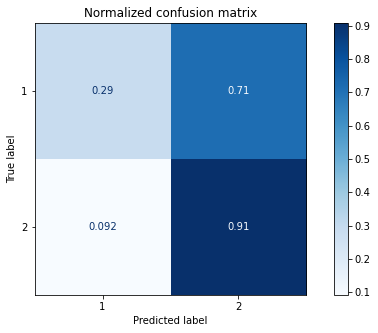

Best model with rbf kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8141025641025642
train score: 0.976923076923077
test score: 0.7994505494505495

cv score: 0.8141025641025642
train score: 0.9560975609756097
test score: 0.8759124087591241

Confusion matrix, without normalization
[[  5   2]
 [ 15 115]]


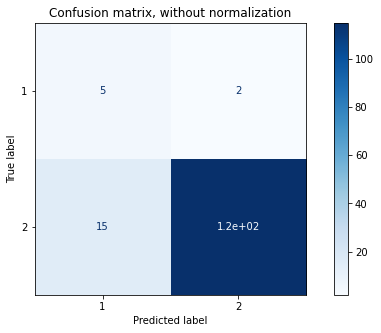

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.11538462 0.88461538]]


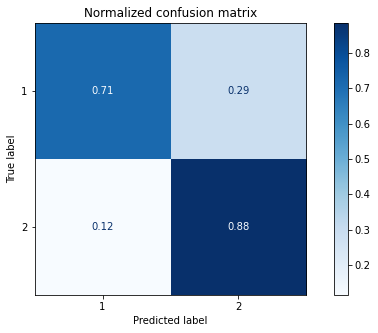

Best model with sigmoid kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7589743589743589
train score: 0.808974358974359
test score: 0.7357142857142858

cv score: 0.7589743589743589
train score: 0.9073170731707317
test score: 0.8832116788321168

Confusion matrix, without normalization
[[  4   3]
 [ 13 117]]


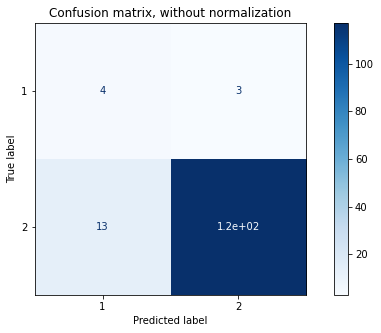

Normalized confusion matrix
[[0.57142857 0.42857143]
 [0.1        0.9       ]]


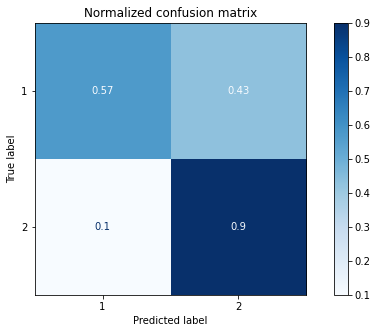

SVM FOR  triangle
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.72
train score: 0.8225
test score: 0.8223684210526316

cv score: 0.72
train score: 0.8439024390243902
test score: 0.8905109489051095

Confusion matrix, without normalization
[[  3   1]
 [ 14 119]]


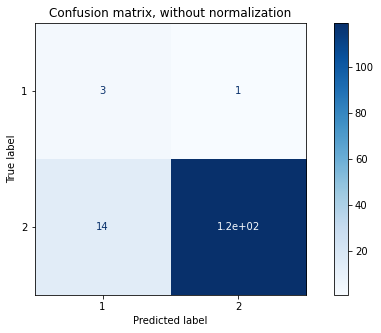

Normalized confusion matrix
[[0.75       0.25      ]
 [0.10526316 0.89473684]]


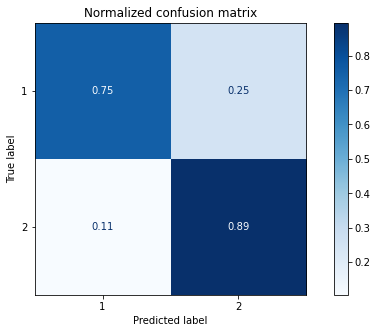

Best model with rbf kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7175
train score: 0.815
test score: 0.7960526315789473

cv score: 0.7175
train score: 0.8292682926829268
test score: 0.8394160583941606

Confusion matrix, without normalization
[[  3   1]
 [ 21 112]]


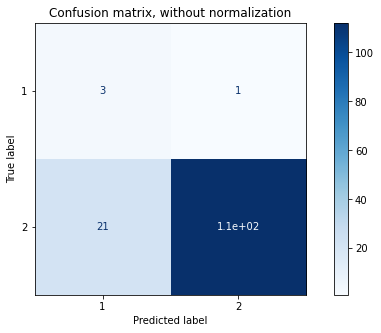

Normalized confusion matrix
[[0.75       0.25      ]
 [0.15789474 0.84210526]]


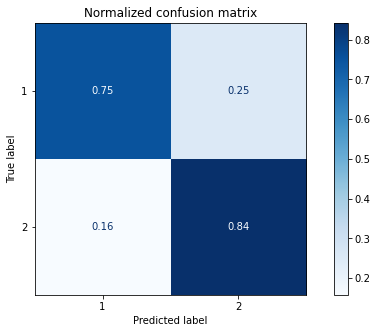

Best model with sigmoid kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7575
train score: 0.765
test score: 0.7330827067669172

cv score: 0.7575
train score: 0.5414634146341464
test score: 0.48175182481751827

Confusion matrix, without normalization
[[ 4  0]
 [71 62]]


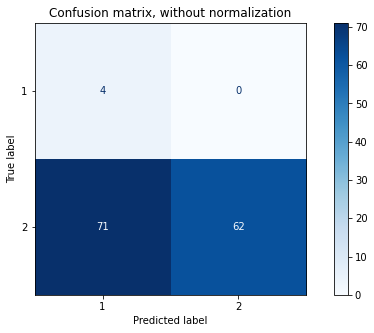

Normalized confusion matrix
[[1.         0.        ]
 [0.53383459 0.46616541]]


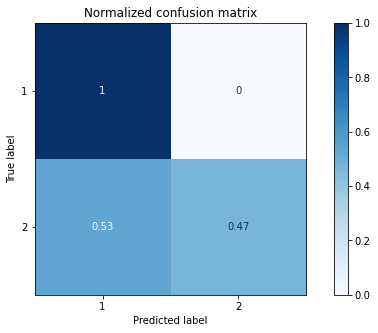

SVM FOR  rett_diag
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.9619871794871795
train score: 0.9543147208121827
test score: 0.9274809160305344

cv score: 0.9619871794871795
train score: 0.9121951219512195
test score: 0.8613138686131386

Confusion matrix, without normalization
[[  6   0]
 [ 19 112]]


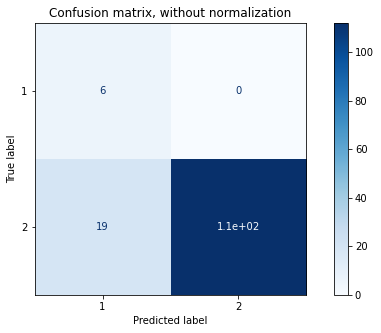

Normalized confusion matrix
[[1.         0.        ]
 [0.14503817 0.85496183]]


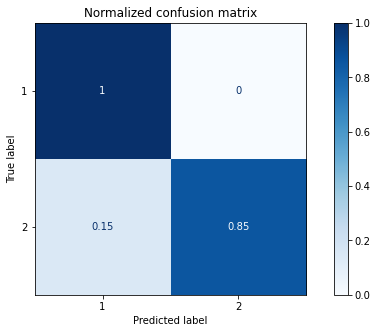

Best model with rbf kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.9592948717948719
train score: 0.9543147208121827
test score: 0.9465648854961832

cv score: 0.9592948717948719
train score: 0.9121951219512195
test score: 0.8978102189781022

Confusion matrix, without normalization
[[  6   0]
 [ 14 117]]


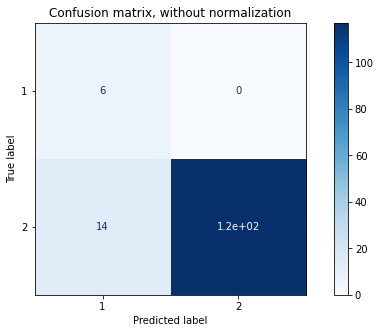

Normalized confusion matrix
[[1.         0.        ]
 [0.10687023 0.89312977]]


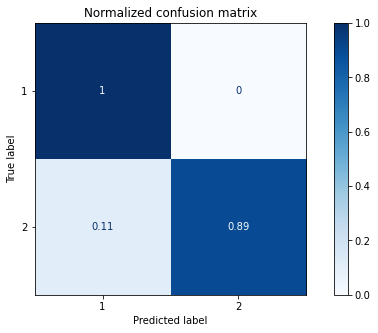

Best model with sigmoid kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.9516666666666668
train score: 0.9568527918781726
test score: 0.9580152671755725

cv score: 0.9516666666666668
train score: 0.9170731707317074
test score: 0.9197080291970803

Confusion matrix, without normalization
[[  6   0]
 [ 11 120]]


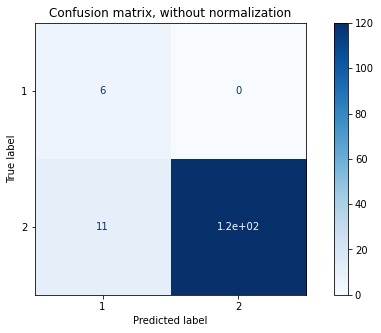

Normalized confusion matrix
[[1.         0.        ]
 [0.08396947 0.91603053]]


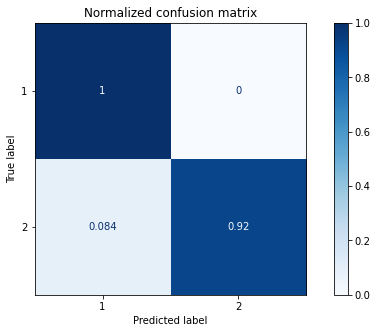

SVM FOR  rect
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=10.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8296794871794871
train score: 0.8463149078726968
test score: 0.5686090225563909

cv score: 0.8296794871794871
train score: 0.8585365853658536
test score: 0.8686131386861314

Confusion matrix, without normalization
[[  1   3]
 [ 15 118]]


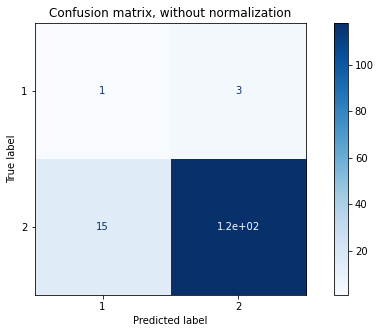

Normalized confusion matrix
[[0.25       0.75      ]
 [0.11278195 0.88721805]]


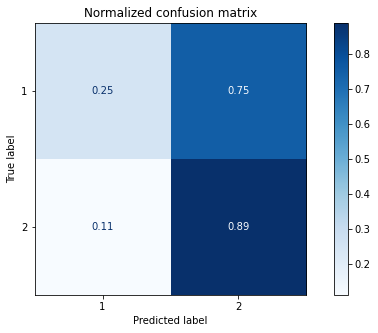

Best model with rbf kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8246153846153847
train score: 0.833752093802345
test score: 0.43609022556390975

cv score: 0.8246153846153847
train score: 0.8341463414634146
test score: 0.8467153284671532

Confusion matrix, without normalization
[[  0   4]
 [ 17 116]]


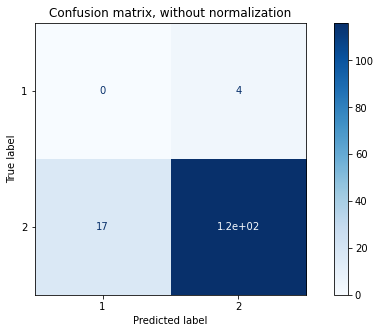

Normalized confusion matrix
[[0.         1.        ]
 [0.12781955 0.87218045]]


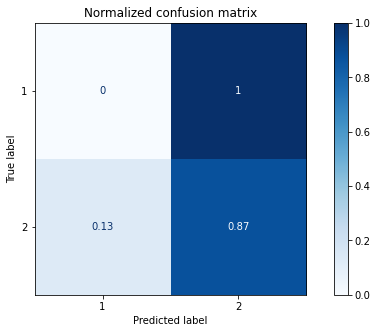

Best model with sigmoid kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8221153846153847
train score: 0.8387772194304858
test score: 0.43609022556390975

cv score: 0.8221153846153847
train score: 0.8439024390243902
test score: 0.8467153284671532

Confusion matrix, without normalization
[[  0   4]
 [ 17 116]]


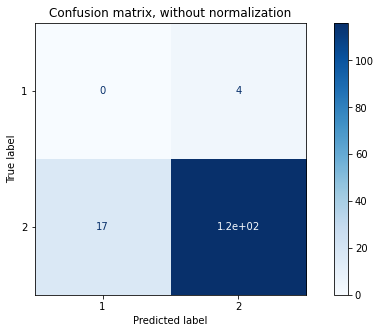

Normalized confusion matrix
[[0.         1.        ]
 [0.12781955 0.87218045]]


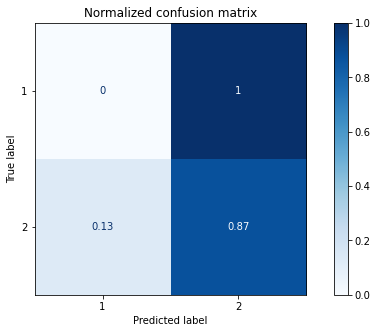

SVM FOR  cross_vert
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7042948717948718
train score: 0.7049492385786802
test score: 0.4954545454545455

cv score: 0.7042948717948718
train score: 0.6634146341463415
test score: 0.583941605839416

Confusion matrix, without normalization
[[ 2  3]
 [54 78]]


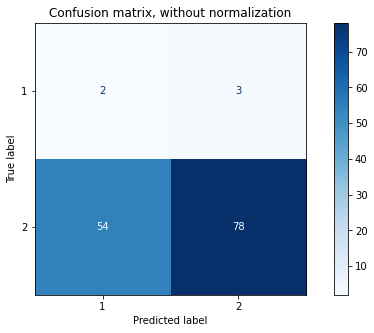

Normalized confusion matrix
[[0.4        0.6       ]
 [0.40909091 0.59090909]]


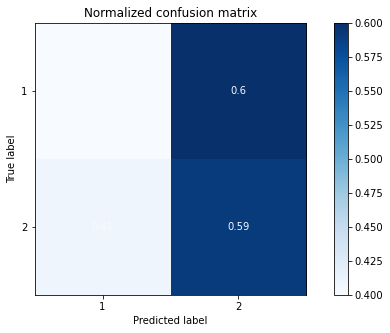

Best model with rbf kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.6646153846153846
train score: 0.7151015228426396
test score: 0.621969696969697

cv score: 0.6646153846153846
train score: 0.6829268292682927
test score: 0.6423357664233577

Confusion matrix, without normalization
[[ 3  2]
 [47 85]]


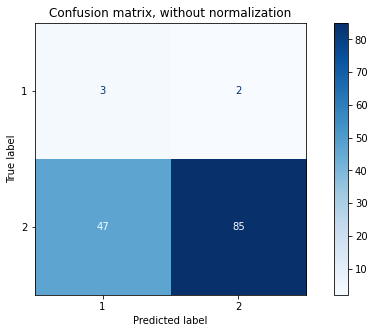

Normalized confusion matrix
[[0.6        0.4       ]
 [0.35606061 0.64393939]]


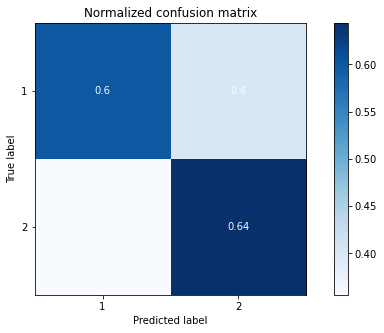

Best model with sigmoid kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.6493589743589743
train score: 0.7227157360406091
test score: 0.5916666666666667

cv score: 0.6493589743589743
train score: 0.697560975609756
test score: 0.583941605839416

Confusion matrix, without normalization
[[ 3  2]
 [55 77]]


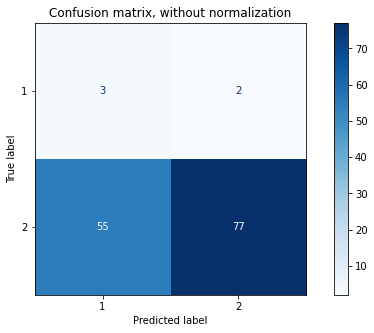

Normalized confusion matrix
[[0.6        0.4       ]
 [0.41666667 0.58333333]]


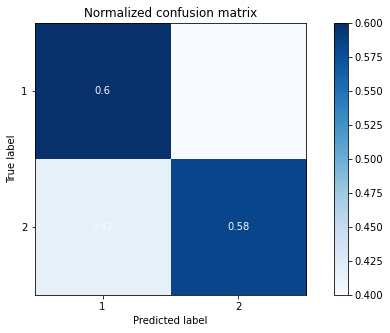

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import joblib
y = y_data
for i in range(len(patterns)):

    print("SVM FOR ", patternsName[i])
    X_pixel = X[i]
    y_current = y[i]
    X_train, X_test, y_train, y_test = train_test_split(X_pixel, y_current, test_size=0.4, random_state=0, stratify=y_current)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
        'coef0': np.linspace(-10, 10, 5),
        'degree': [2, 3, 4]}
    svm_poly_pixel = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                            cv=5, scoring='balanced_accuracy', refit=True)
    svm_poly_pixel.fit(X_train_scaled, y_train)
    print('poly done')
    # RBF
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    rbf_poly_pixel = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, 
                            cv=5, scoring='balanced_accuracy', refit=True)
    rbf_poly_pixel.fit(X_train_scaled, y_train)
    print('rbf done')
    # Sigmoid
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'coef0': np.linspace(-10, 10, 5)}
    sigm_poly_pixel = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid, 
                            cv=5, scoring='balanced_accuracy', refit=True)
    sigm_poly_pixel.fit(X_train_scaled, y_train)
    print('sigmoid done')
    for m in [svm_poly_pixel, rbf_poly_pixel, sigm_poly_pixel]:
        cv_score = m.best_score_
        m = m.best_estimator_  
        print("Best model with {} kernel:".format(m.get_params()['kernel']))    
        print(m)     
        train_acc = balanced_accuracy_score(y_train, m.predict(X_train_scaled))
        test_acc = balanced_accuracy_score(y_test, m.predict(X_test_scaled))
        print("cv score: {}".format(cv_score))
        print("train score: {}".format(train_acc))
        print("test score: {}\n".format(test_acc))
        train_acc = accuracy_score(y_train, m.predict(X_train_scaled))
        test_acc = accuracy_score(y_test, m.predict(X_test_scaled))
        print("cv score: {}".format(cv_score))
        print("train score: {}".format(train_acc))
        print("test score: {}\n".format(test_acc))
        # plot_decision_regions(X_test_scaled, y_test, clf=m, legend=2)
        titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
        class_names = ['1', '2']
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(m, X_test_scaled, y_test,
                                        display_labels=class_names,
                                        cmap=plt.cm.Blues,
                                        normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
            plt.show()
            plt.close('all')
        
        joblib.dump(m, '../new_models/'+ patternsName[i] +'_model_' + m.get_params()['kernel'] + '.joblib')
    joblib.dump(scaler, '../new_models/'+patternsName[i] +'_scaler.joblib')



# SVM from hardcoded ROIs

In [7]:
import cv2
p_dst = [(382, 219),(852, 219), (852, 537), (382, 537)]
def computeHomographyRhomb( points):
    point_rhomb = points[2] + (1,)
    mask = np.ones(5, dtype=int)
    mask[2] = 0
    right_points = np.array(points)[np.ma.make_mask(mask)]
    hm, status = cv2.findHomography(np.array(right_points), np.array(p_dst))
    new_point = np.dot(hm, point_rhomb)
    new_point = tuple(np.round(new_point/new_point[2]).astype(int))
    center = new_point[0:2]
    return center

In [13]:


root = '../' #modificare se cartella rinominata
results_folder = os.path.join(root, 'results')
training_folder = os.path.join(root, 'dataset', 'training')
df_rail = pd.read_csv(os.path.join(results_folder, 'scores.csv'), header=0, usecols=['names', 'rect'], index_col='names', converters={'rect': to_tuple})
plt.rcParams['figure.figsize'] = [10, 5]
pixels = []

dataset = pd.read_csv(os.path.join(training_folder, 'DatabaseScoreByHand_training.csv'), header=0, index_col='CODICE', delimiter=',')
# print(linee_d.value_counts())
scoring=np.zeros(4)
hom_folder = os.path.join(root, 'dataset', 'threshed')
file_homog = pd.read_json(os.path.join(hom_folder, 'points.txt'), lines=True).set_index('name')

patterns = ['PATTERN5', 'PATTERN10', 'PATTERN12', 'PATTERN18', 'PATTERN3', 'PATTERN15', 'PATTERN17' ]
patternsName = ['cross', 'face', 'rail', 'triangle', 'rett_diag', 'rect', 'cross_vert']
coordinatesROI =  [
    [324,119,378,373],
    [742, 287, 829, 373],
    [617, 383, 847, 534],
    [852, 229, 531],
    [379, 300, 502, 456],
    [360, 525, 510, 680],
    [502, 540, 810, 661]
]

y_data = []
X = [] 

for i in range(len(patterns)):
  coords = [852, 229, 1031, 531]#cambiare qui
  y_data.append([])
  X.append([])
  linee_d = dataset.loc[:, patterns[i]] #cambiare qui
  for img_path in os.listdir(hom_folder):
      if img_path.lower().endswith('.png'):
        name = img_path[:-4]      
        if name in linee_d.index:
          score = int(linee_d.loc[name])       
          scoring[score] += 1
          if i == 3:
            points = file_homog.loc[name].values[0]
            points = [tuple(x) for x in points]
            r_points = computeHomographyRhomb(points)
            coordinatesROI[3].insert(2, r_points[0])
          if score == 0:
            y_data[i].append(0)
            img = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.blur(img, (5, 5))
            if img_path[:-4] in df_rail.index:
              # rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
              rail_bbox = coordinatesROI[i]
              external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[2], rail_bbox[1]), (rail_bbox[2], rail_bbox[3]), (rail_bbox[0],rail_bbox[3])]
              roiSplit = getSplitsFromROI(external)
              roiPixels = []
              imgcopy = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_COLOR)
              for roi in range(len(roiSplit)):
                background, _ = getBackground(roiSplit[roi], img, False)
                pixel = np.sum(np.divide(background, 255))
              # print('pixels {}'.format(pixel))
                imgcopy = cv2.rectangle(imgcopy, (roiSplit[roi][0][0], roiSplit[roi][0][1]), (roiSplit[roi][2][0], roiSplit[roi][2][1]), (255,0,0), 3)
                roiPixels.append(pixel)
              print(roiPixels, " ---- ", score)
              X[i].append(roiPixels)
            # else:
            #   x = coords[0] 
            #   y = coords[1] 
            #   w = np.abs(coords[0] - coords[2])
            #   h = np.abs(coords[1] - coords[3])
            #   external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            #   background, _ = getBackground(external, img, False)
            #   pixel = np.sum(np.divide(background, 255))
            #   # print('pixels {}'.format(pixel))
            #   X[i].append([0, pixel])
            # print('score 0, pixels {}'.format(pixel))
            
          else:
            y_data[i].append(1)
            img = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.blur(img, (5, 5))
            if img_path[:-4] in df_rail.index:
              rail_bbox = coordinatesROI[i]
              external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[2], rail_bbox[1]), (rail_bbox[2], rail_bbox[3]), (rail_bbox[0],rail_bbox[3])]
              roiSplit = getSplitsFromROI(external)
              roiPixels = []
              imgcopy = cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_COLOR)
              for roi in range(len(roiSplit)):
                background, _ = getBackground(roiSplit[roi], img, False)
                pixel = np.sum(np.divide(background, 255))
              # print('pixels {}'.format(pixel))
                imgcopy = cv2.rectangle(imgcopy, (roiSplit[roi][0][0], roiSplit[roi][0][1]), (roiSplit[roi][2][0], roiSplit[roi][2][1]), (255,0,0), 3)
                roiPixels.append(pixel)
              print(roiPixels, " ---- ", score)
              X[i].append(roiPixels)
            # else:
            #   x = coords[0] 
            #   y = coords[1] 
            #   w = np.abs(coords[0] - coords[2])
            #   h = np.abs(coords[1] - coords[3])
            #   external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            #   background, _ = getBackground(external, img, False)
            #   pixel = np.sum(np.divide(background, 255))
            #   # print('pixels {}'.format(pixel))
            #   X[i].append([0, pixel])
            # print('score 1, pixels {}'.format(pixel))


  # print(scoring)
  X[i] = np.array(X[i])
  y_data[i] = np.array(y_data[i])
  print(X[i].shape, y_data[i].shape)
  print("done ", patterns[i], " ", patternsName[i])
            



[446.0, 306.0, 333.6078431372548, 350.1960784313725]  ----  2
[394.0, 503.0, 302.0, 528.4313725490198]  ----  3
[109.60000000000002, 359.0, 178.0, 97.0]  ----  1
[437.156862745098, 179.0, 83.73725490196077, 0.19607843137254902]  ----  1
[298.0, 145.0, 358.0, 454.0]  ----  3
[99.0, 69.9921568627451, 50.20392156862745, 389.0]  ----  3
[281.1372549019607, 69.53725490196078, 284.00000000000006, 59.443137254901956]  ----  3
[576.0, 215.2156862745098, 375.0, 14.0]  ----  3
[343.0, 348.0, 383.0, 243.20000000000007]  ----  3
[425.0, 190.0, 347.0, 222.0]  ----  3
[257.63921568627444, 44.4, 355.764705882353, 182.1098039215686]  ----  3
[65.0, 100.0, 347.0, 289.0]  ----  0
[351.0, 401.0, 472.0, 121.72549019607843]  ----  1
[332.46274509803914, 33.239215686274505, 269.749019607843, 38.13333333333333]  ----  3
[0.0, 110.0, 79.0, 431.0]  ----  3
[114.878431372549, 13.2, 117.49019607843137, 90.6]  ----  1
[419.0, 152.76470588235293, 359.33333333333337, 434.0]  ----  3
[216.4196078431373, 38.596078431

SVM FOR  cross
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8893669985775249
train score: 0.8786393345216874
test score: 0.7493333333333333

cv score: 0.8893669985775249
train score: 0.824390243902439
test score: 0.8175182481751825

Confusion matrix, without normalization
[[  8   4]
 [ 21 104]]


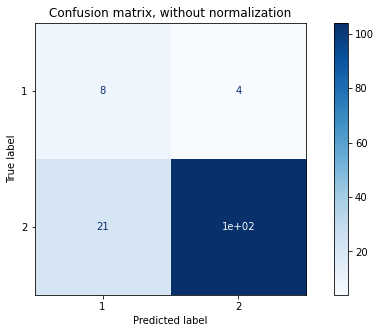

Normalized confusion matrix
[[0.66666667 0.33333333]
 [0.168      0.832     ]]


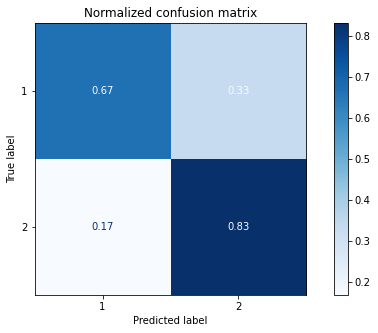

Best model with rbf kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8819582740635372
train score: 0.9732620320855615
test score: 0.851

cv score: 0.8819582740635372
train score: 0.9512195121951219
test score: 0.9343065693430657

Confusion matrix, without normalization
[[  9   3]
 [  6 119]]


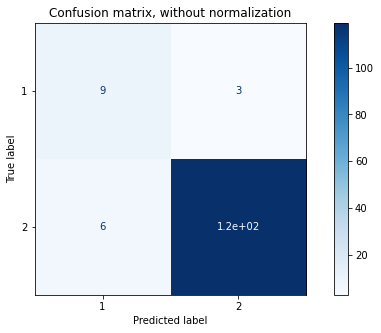

Normalized confusion matrix
[[0.75  0.25 ]
 [0.048 0.952]]


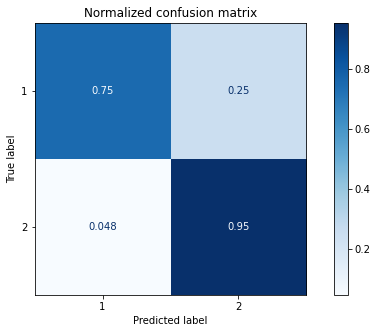

Best model with sigmoid kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8951872925557136
train score: 0.8952762923351159
test score: 0.7676666666666667

cv score: 0.8951872925557136
train score: 0.9463414634146341
test score: 0.9197080291970803

Confusion matrix, without normalization
[[  7   5]
 [  6 119]]


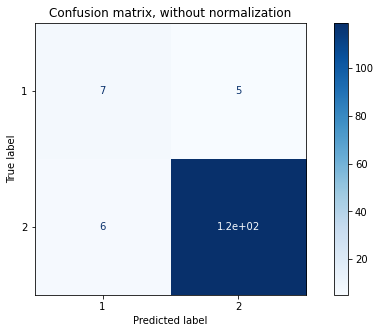

Normalized confusion matrix
[[0.58333333 0.41666667]
 [0.048      0.952     ]]


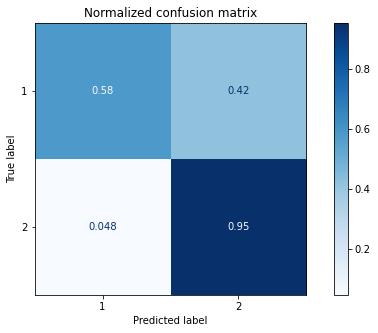

SVM FOR  face
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.9435897435897435
train score: 0.9435897435897436
test score: 0.8362637362637362

cv score: 0.9435897435897435
train score: 0.8926829268292683
test score: 0.8175182481751825

Confusion matrix, without normalization
[[  6   1]
 [ 24 106]]


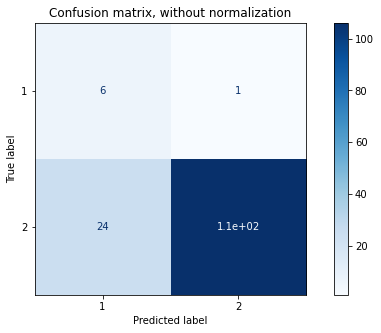

Normalized confusion matrix
[[0.85714286 0.14285714]
 [0.18461538 0.81538462]]


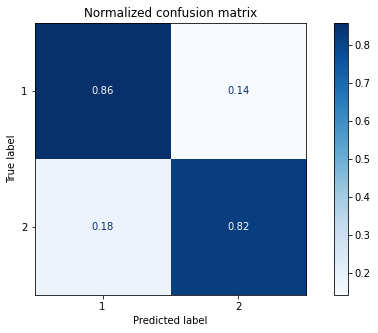

Best model with rbf kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.941025641025641
train score: 0.941025641025641
test score: 0.843956043956044

cv score: 0.941025641025641
train score: 0.8878048780487805
test score: 0.8321167883211679

Confusion matrix, without normalization
[[  6   1]
 [ 22 108]]


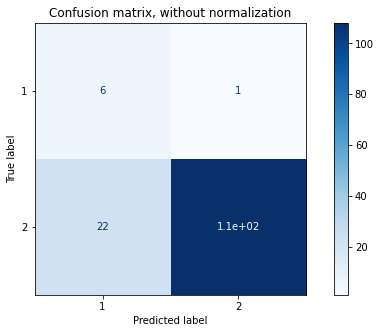

Normalized confusion matrix
[[0.85714286 0.14285714]
 [0.16923077 0.83076923]]


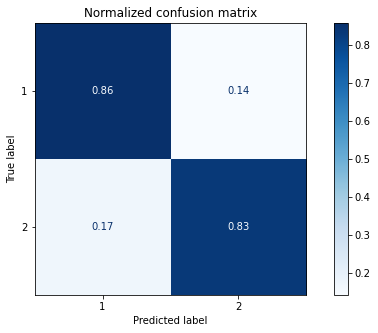

Best model with sigmoid kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.9410256410256409
train score: 0.9384615384615385
test score: 0.843956043956044

cv score: 0.9410256410256409
train score: 0.8829268292682927
test score: 0.8321167883211679

Confusion matrix, without normalization
[[  6   1]
 [ 22 108]]


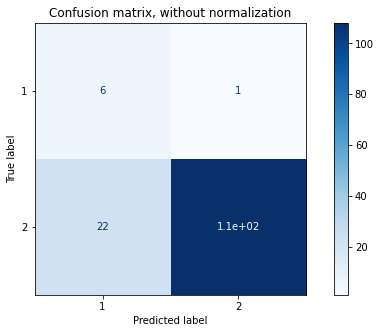

Normalized confusion matrix
[[0.85714286 0.14285714]
 [0.16923077 0.83076923]]


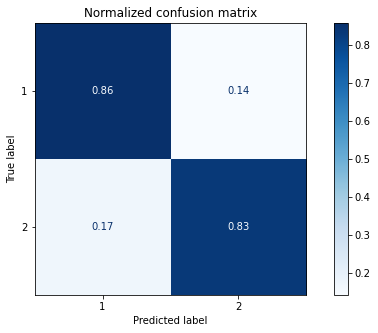

SVM FOR  rail
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7461538461538462
train score: 0.7410256410256411
test score: 0.6241758241758242

cv score: 0.7461538461538462
train score: 0.6878048780487804
test score: 0.6715328467153284

Confusion matrix, without normalization
[[ 4  3]
 [42 88]]


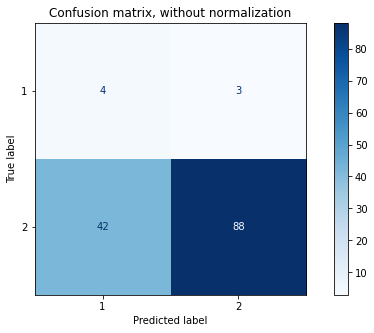

Normalized confusion matrix
[[0.57142857 0.42857143]
 [0.32307692 0.67692308]]


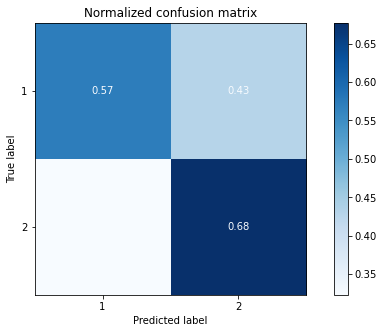

Best model with rbf kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8153846153846154
train score: 0.7833333333333333
test score: 0.760989010989011

cv score: 0.8153846153846154
train score: 0.8585365853658536
test score: 0.8029197080291971

Confusion matrix, without normalization
[[  5   2]
 [ 25 105]]


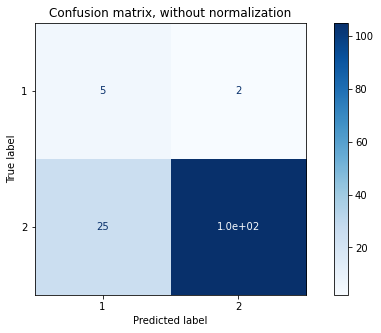

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.19230769 0.80769231]]


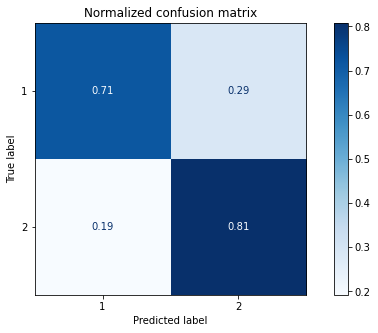

Best model with sigmoid kernel:
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7743589743589743
train score: 0.7794871794871795
test score: 0.7302197802197803

cv score: 0.7743589743589743
train score: 0.7609756097560976
test score: 0.7445255474452555

Confusion matrix, without normalization
[[ 5  2]
 [33 97]]


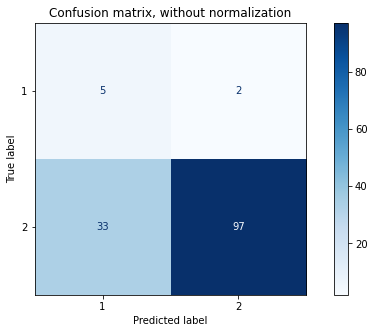

Normalized confusion matrix
[[0.71428571 0.28571429]
 [0.25384615 0.74615385]]


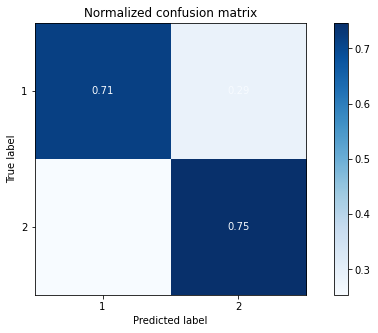

SVM FOR  triangle
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=5.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.7750000000000001
train score: 0.8775
test score: 0.6099624060150376

cv score: 0.7750000000000001
train score: 0.9512195121951219
test score: 0.948905109489051

Confusion matrix, without normalization
[[  1   3]
 [  4 129]]


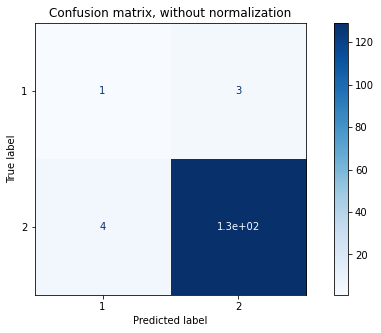

Normalized confusion matrix
[[0.25       0.75      ]
 [0.03007519 0.96992481]]


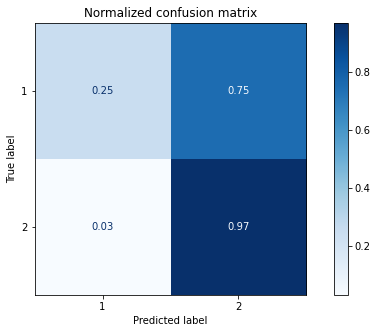

Best model with rbf kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7675
train score: 0.8725
test score: 0.6137218045112782

cv score: 0.7675
train score: 0.9414634146341463
test score: 0.9562043795620438

Confusion matrix, without normalization
[[  1   3]
 [  3 130]]


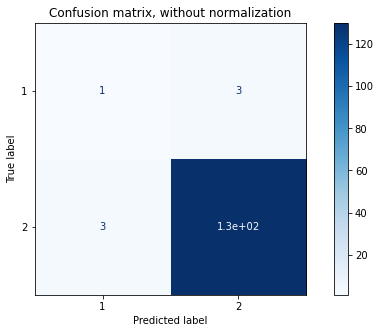

Normalized confusion matrix
[[0.25       0.75      ]
 [0.02255639 0.97744361]]


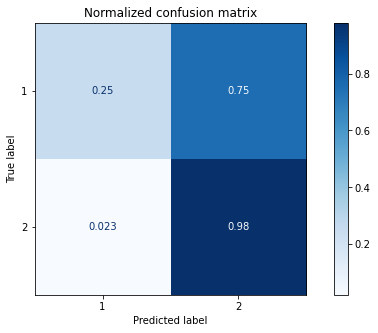

Best model with sigmoid kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-10.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.8649999999999999
train score: 0.855
test score: 0.5723684210526316

cv score: 0.8649999999999999
train score: 0.9073170731707317
test score: 0.8759124087591241

Confusion matrix, without normalization
[[  1   3]
 [ 14 119]]


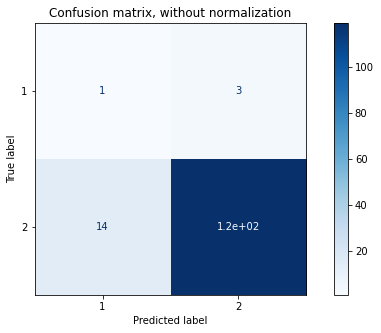

Normalized confusion matrix
[[0.25       0.75      ]
 [0.10526316 0.89473684]]


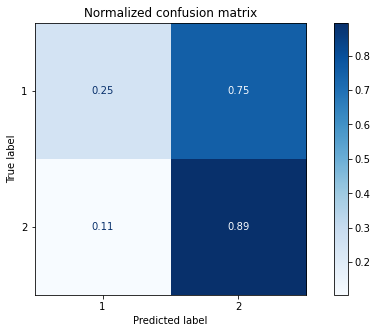

SVM FOR  rett_diag
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.9060897435897435
train score: 0.8613578680203046
test score: 0.8136132315521629

cv score: 0.9060897435897435
train score: 0.848780487804878
test score: 0.7956204379562044

Confusion matrix, without normalization
[[  5   1]
 [ 27 104]]


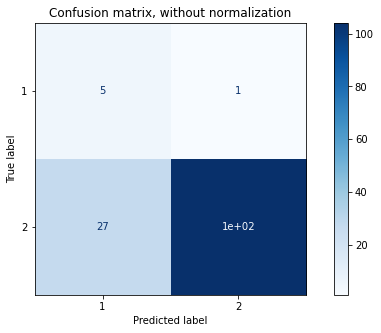

Normalized confusion matrix
[[0.83333333 0.16666667]
 [0.20610687 0.79389313]]


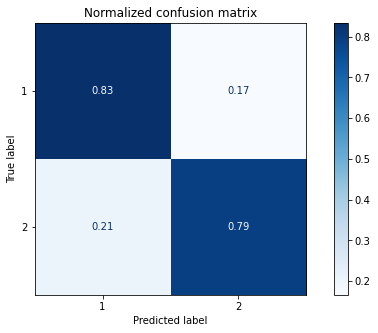

Best model with rbf kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8696794871794872
train score: 0.9720812182741116
test score: 0.7646310432569974

cv score: 0.8696794871794872
train score: 0.9463414634146341
test score: 0.8540145985401459

Confusion matrix, without normalization
[[  4   2]
 [ 18 113]]


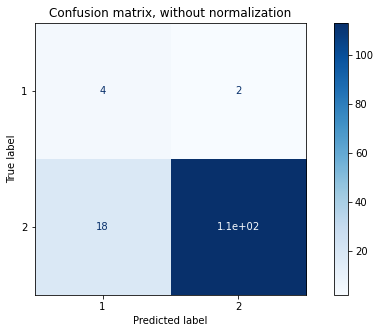

Normalized confusion matrix
[[0.66666667 0.33333333]
 [0.13740458 0.86259542]]


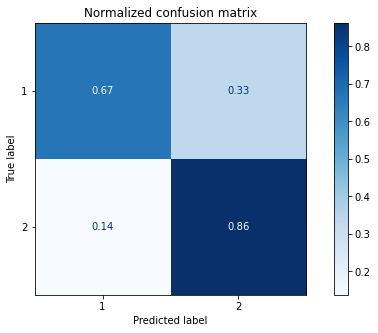

Best model with sigmoid kernel:
SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=-5.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
cv score: 0.9315384615384616
train score: 0.934010152284264
test score: 0.8250636132315522

cv score: 0.9315384615384616
train score: 0.8731707317073171
test score: 0.8175182481751825

Confusion matrix, without normalization
[[  5   1]
 [ 24 107]]


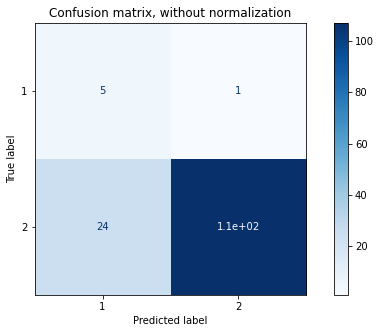

Normalized confusion matrix
[[0.83333333 0.16666667]
 [0.18320611 0.81679389]]


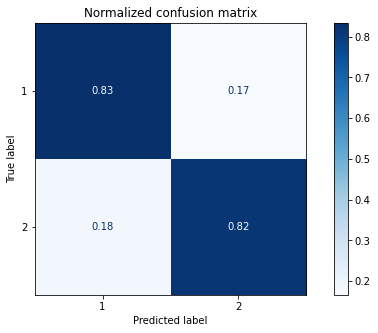

SVM FOR  rect
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=-5.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.864423076923077
train score: 0.8567839195979899
test score: 0.7133458646616542

cv score: 0.864423076923077
train score: 0.7219512195121951
test score: 0.6788321167883211

Confusion matrix, without normalization
[[ 3  1]
 [43 90]]


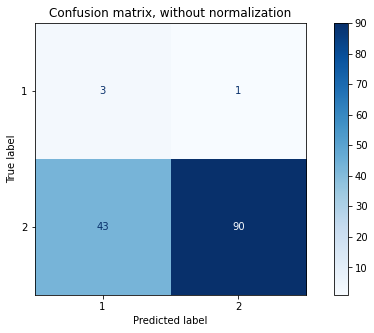

Normalized confusion matrix
[[0.75       0.25      ]
 [0.32330827 0.67669173]]


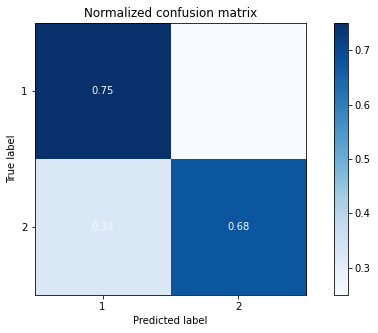

Best model with rbf kernel:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8774358974358976
train score: 0.9698492462311558
test score: 0.5986842105263157

cv score: 0.8774358974358976
train score: 0.9414634146341463
test score: 0.927007299270073

Confusion matrix, without normalization
[[  1   3]
 [  7 126]]


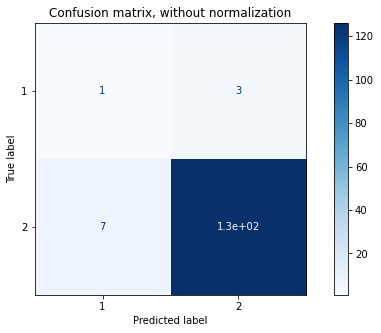

Normalized confusion matrix
[[0.25       0.75      ]
 [0.05263158 0.94736842]]


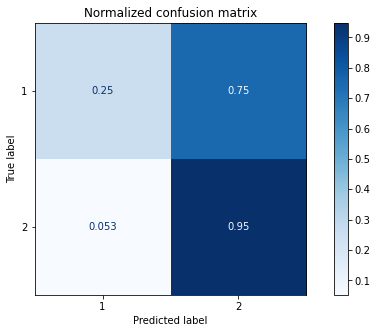

Best model with sigmoid kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=-5.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.9322435897435897
train score: 0.9346733668341709
test score: 0.924812030075188

cv score: 0.9322435897435897
train score: 0.8731707317073171
test score: 0.8540145985401459

Confusion matrix, without normalization
[[  4   0]
 [ 20 113]]


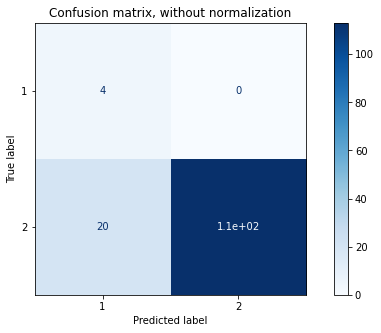

Normalized confusion matrix
[[1.         0.        ]
 [0.15037594 0.84962406]]


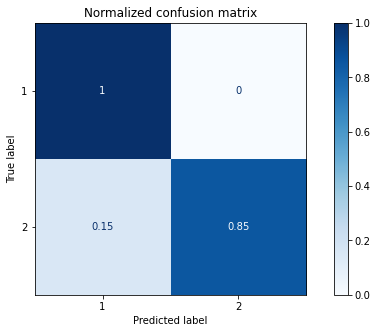

SVM FOR  cross_vert
poly done
rbf done
sigmoid done
Best model with poly kernel:
SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8290384615384616
train score: 0.9263959390862944
test score: 0.746969696969697

cv score: 0.8290384615384616
train score: 0.8585365853658536
test score: 0.8832116788321168

Confusion matrix, without normalization
[[  3   2]
 [ 14 118]]


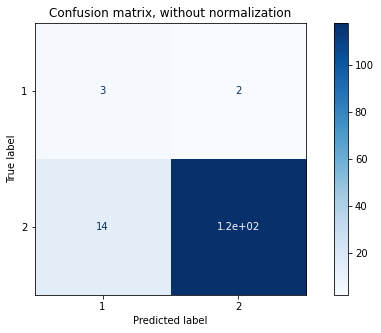

Normalized confusion matrix
[[0.6        0.4       ]
 [0.10606061 0.89393939]]


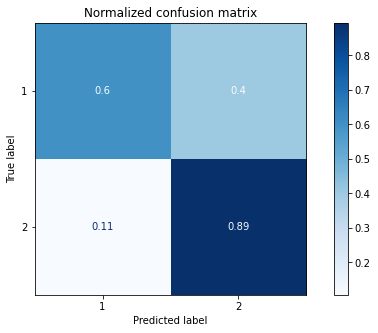

Best model with rbf kernel:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7716025641025641
train score: 0.871510152284264
test score: 0.7318181818181818

cv score: 0.7716025641025641
train score: 0.8682926829268293
test score: 0.8540145985401459

Confusion matrix, without normalization
[[  3   2]
 [ 18 114]]


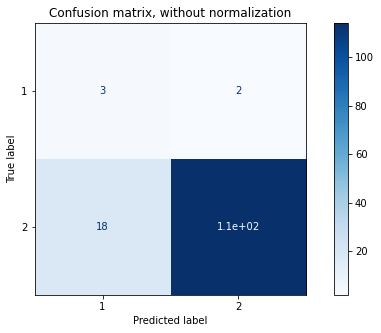

Normalized confusion matrix
[[0.6        0.4       ]
 [0.13636364 0.86363636]]


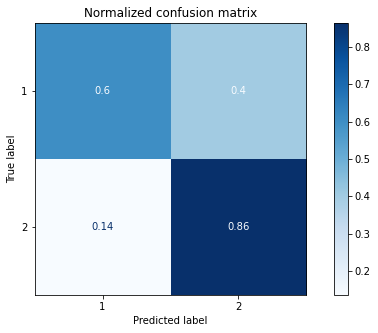

Best model with sigmoid kernel:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.7436538461538461
train score: 0.8283629441624365
test score: 0.7825757575757576

cv score: 0.7436538461538461
train score: 0.7853658536585366
test score: 0.7664233576642335

Confusion matrix, without normalization
[[  4   1]
 [ 31 101]]


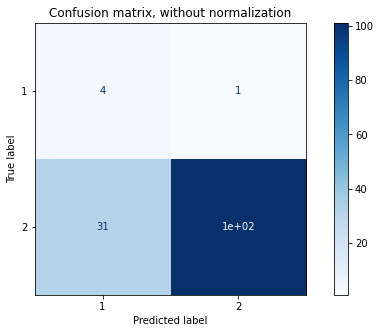

Normalized confusion matrix
[[0.8        0.2       ]
 [0.23484848 0.76515152]]


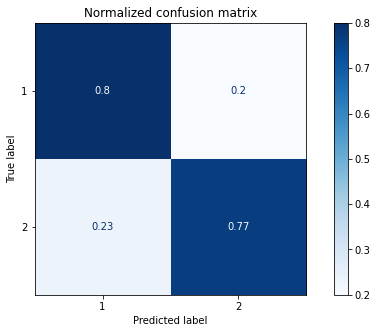

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import joblib
y = y_data
for i in range(len(patterns)):

    print("SVM FOR ", patternsName[i])
    X_pixel = X[i]
    y_current = y[i]
    X_train, X_test, y_train, y_test = train_test_split(X_pixel, y_current, test_size=0.4, random_state=0, stratify=y_current)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
        'coef0': np.linspace(-10, 10, 5),
        'degree': [2, 3, 4]}
    svm_poly_pixel = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                            cv=5, scoring='balanced_accuracy', refit=True)
    svm_poly_pixel.fit(X_train_scaled, y_train)
    print('poly done')
    # RBF
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    rbf_poly_pixel = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, 
                            cv=5, scoring='balanced_accuracy', refit=True)
    rbf_poly_pixel.fit(X_train_scaled, y_train)
    print('rbf done')
    # Sigmoid
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'coef0': np.linspace(-10, 10, 5)}
    sigm_poly_pixel = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid, 
                            cv=5, scoring='balanced_accuracy', refit=True)
    sigm_poly_pixel.fit(X_train_scaled, y_train)
    print('sigmoid done')
    for m in [svm_poly_pixel, rbf_poly_pixel, sigm_poly_pixel]:
        cv_score = m.best_score_
        m = m.best_estimator_  
        print("Best model with {} kernel:".format(m.get_params()['kernel']))    
        print(m)     
        train_acc = balanced_accuracy_score(y_train, m.predict(X_train_scaled))
        test_acc = balanced_accuracy_score(y_test, m.predict(X_test_scaled))
        print("cv score: {}".format(cv_score))
        print("train score: {}".format(train_acc))
        print("test score: {}\n".format(test_acc))
        train_acc = accuracy_score(y_train, m.predict(X_train_scaled))
        test_acc = accuracy_score(y_test, m.predict(X_test_scaled))
        print("cv score: {}".format(cv_score))
        print("train score: {}".format(train_acc))
        print("test score: {}\n".format(test_acc))
        # plot_decision_regions(X_test_scaled, y_test, clf=m, legend=2)
        titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
        class_names = ['1', '2']
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(m, X_test_scaled, y_test,
                                        display_labels=class_names,
                                        cmap=plt.cm.Blues,
                                        normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
            plt.show()
            plt.close('all')
        
        joblib.dump(m, '../new_models/'+ patternsName[i] +'_model_' + m.get_params()['kernel'] + '.joblib')
    joblib.dump(scaler, '../new_models/'+patternsName[i] +'_scaler.joblib')

